# Exercise 2.1

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need

In [1]:
%matplotlib inline
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU. This is important so things run faster.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [3]:
batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

0it [00:00, ?it/s]

100%|█████████▉| 169877504/170498071 [00:14<00:00, 9015482.45it/s] 

Files already downloaded and verified


170500096it [00:30, 9015482.45it/s]                               

* Make a CNN to train on the CIFAR10 dataset

In [66]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU())

        self.fully_connected = nn.Sequential(
                nn.BatchNorm1d(8*8*64),
                nn.Linear(8*8*64, 512),
                nn.ReLU(),
                nn.Linear(512, 10),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [78]:
model = Network()
model.to(device)

Network(
  (convolutional): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
  )
  (fully_connected): Sequential(
    (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): Softmax()
  )
)

In [75]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    train_acc_all = []
    test_acc_all = []

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = F.nll_loss(torch.log(output), target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target==predicted).sum().item()
        train_acc = train_correct/len(trainset)
        test_acc = test_correct/len(testset)
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    return test_acc_all, train_acc_all

 * Train the network and plot the training and test accuracys with the epoch number on the x-axis

In [79]:
# using SGD optimizer
sgd_optimizer = torch.optim.SGD(model.parameters(), lr=.001)
test_acc_sgd, train_acc_sgd = train(model, sgd_optimizer)

Accuracy train: 23.4%	 test: 29.6%


Accuracy train: 32.4%	 test: 36.8%


Accuracy train: 37.6%	 test: 39.4%


Accuracy train: 39.9%	 test: 41.1%


Accuracy train: 42.0%	 test: 41.0%


Accuracy train: 43.7%	 test: 40.0%


Accuracy train: 44.9%	 test: 40.6%


Accuracy train: 46.4%	 test: 45.1%


Accuracy train: 47.7%	 test: 47.0%


Accuracy train: 49.0%	 test: 49.5%


In [76]:
# using Adam optimizer
adam_optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
test_acc_adam, train_acc_adam = train(model, adam_optimizer)

Accuracy train: 45.2%	 test: 52.8%


Accuracy train: 57.8%	 test: 57.7%


Accuracy train: 62.8%	 test: 60.4%


Accuracy train: 66.7%	 test: 60.2%


Accuracy train: 70.1%	 test: 59.6%


Accuracy train: 73.3%	 test: 65.2%


Accuracy train: 76.1%	 test: 65.4%


Accuracy train: 78.8%	 test: 65.4%


Accuracy train: 81.3%	 test: 66.1%


Accuracy train: 84.0%	 test: 65.8%


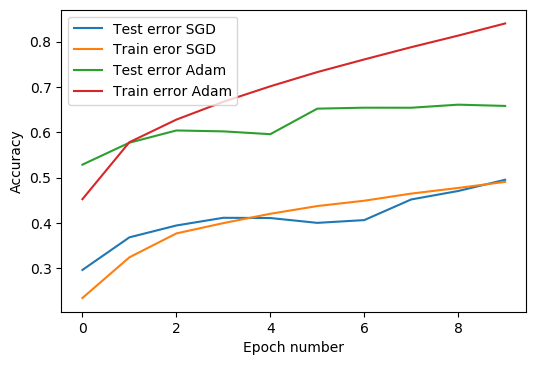

In [80]:
plt.figure(dpi=100)
plt.plot(test_acc_sgd)
plt.plot(train_acc_sgd)
plt.plot(test_acc_adam)
plt.plot(train_acc_adam)

plt.legend(('Test error SGD','Train eror SGD', 'Test error Adam', 'Train error Adam'));
plt.xlabel('Epoch number');
plt.ylabel('Accuracy');

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now we will attempt to create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [166]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.resblock = nn.Sequential(
            nn.Conv2d(n_features,n_features,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_features,n_features,3,padding=1),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.resblock(x) + x
        x = F.relu(x)
        return x

The following code is a sanity of your residual block network

In [167]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for w in res_block.state_dict().values():
    w*=0
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
assert(res_block.state_dict()['resblock.0.weight'].shape==(C, C, 3, 3))
print("Passed sanity check")

Passed sanity check


We define our ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=5):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return out

Let's train our new resnet!

In [ ]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
test_acc, train_acc = train(model, optimizer)
plt.plot(test_acc)
plt.plot(train_acc)
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')